# Respiratory rate estimation

### Description

Seismocardiography([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357) is a very promising technique to measure Heart Rate (HR) and Respiratory Rate (RR) with the detector positioned above sternum. It is generally based on accelerometer and gyroscope readings or a combination of them.
Ballistocardiography([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with combination of both accelerometer and gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., accelerometer platform mounted under the slats of the bed).
MuSe(Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provide by (221e)[https://www.221e.com]. In the context of this project, It allows to record the inertial data necessary for the estimation of SCG and BCG.
The goal of this assignment is to estimate the respiratory rate of an healthy subject, given linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform. The study must be performed on two datasets: the first is the compulsory one (center_sternum.txt) while the second is left at the discretion of the group, among those made available for the assignment.
N.B: Remember that normal beat is around 40-100 bpm.

[Actigraphy](https://en.wikipedia.org/wiki/Actigraphy) is a non-invasive method of monitoring human rest/activity cycles. Data will be provided from sensors gathering data on humans during their day/night activities

### Datasets

The data is provided in .txt file. During this study two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject, while all the other datasets were recorded on the second subject.

This is the first mandatory file:
* center_sternum.txt: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively.

Choose one of the following files in order to complete the task.
1. 1_Stave_supine_static.txt: Sensor placed on a bed stave, under the mattress at the level of the chest. The subject was lying supine on his left and right side.
2. 2_Mattress_supine.txt: Sensor placed on the mattress, near one corner but not under the pillow. The subject laid in the same position as above.
3. 3_Subject_sitting_chair.txt: Sensor placed on the desk: the subject, sitting on a chair, leaned forearms and hands on the desk.
4. 4_Chest_sweater.txt: Sensor placed on the subject chest directly on a sweater.
5. 5_Under_chair.txt: Subject sitting on a chair, sensor placed under the seat of the chair.

All .txt files give 16 columns index, in particular:
* Log Freq stands for the acquisition in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse
system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(README1.txt for the first measurement, and in README_5.txt for the other measurement).
 
### Assignments

Data preparation:

1.1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )

1.2. Plot selected data in function of time and choose a properly time window over which to perform the analysis. Pay attention on time rappresentation and the measurament unit.

1.3. In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.

Time and frequency analysis:

2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical
descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.

2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step.

Filter:

Implement your own filter, trying to extrapolate respiratory rate signal. Hint:

(a) Directly from Fourier Analysis, antitrasform data looking for the most interesting frequency band.

(b) Choose the appropriate Lowpass/Bandpass/Highpass filter.

(c) Wavelet trasform (a powerfull instrument that make a time and frequency analysis of signal). (d) Find another method by yourselves.

Motivate your choice.

Metrics:

4.1. Respiratory Rate Per Minute(RPM): extrapolate RPM, make an histogram of the result. Does it follow a partiular distribution?

4.2. Respiratory Rate Variability(RRV): extrapolate RRV, explain why this parameter is important, and plot the results.

(OPTIONAL) Algorithm: Elaborate a simple algorithm to extrapolate respiratory rate even when filter failed (e.g. look at particular threshold...).

Conclusion:
 Summarise the obtained results, in particular making a comparison between the two files analysed. Highlight limitation and critical issues encountered during the work, motivating the most relevant contribution given by your solution.

N.B: Indicate the contribution, to achieving the result, of each member of the group.

 

### Contacts

* Marco Zanetti <marco.zanetti@unipd.it>
* Marco Signorelli <signo@221e.com>



In [2]:
# package importing cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft #FFT package from scipy
from sklearn.decomposition import PCA #PCA routine from Sci-Kit Learn
import pywt # pywavelets
from scipy.ndimage import gaussian_filter 

# Implementation

The goal of this project is to estimate Respiratory Rate Per Minute (RPM) and Respiratory Rate Variability (RRV) from time series measurements of mechanical quantities such as linear acceleration and angular velocity; said measurements are relative to a Inertial Measurement Unit (IMU) coherently attached to the patient itself or to some structure mechanically connected to him/her (such as the bed).

The available datasets provide measurement of the three spatial components of the linear acceleration vector, angular velocity vector and magnetic field vector (all of them with respect to some previous calibration), plus the spatial orientation of the device given by the quaternion components, and the sampling rate of the given dataset.
## First dataset
### Data preparation
The first dataset we will explore is the `center_sternum.txt` dataset; this dataset has been acquired with the IMU placed directly on the patient's sternum, who was lying supine on the bed. Let's proceed with some initial explorative analysis:

In [3]:
def Data_Frame(data_name):
    """
    Helper function to load a pandas DataFrame from a .txt file such as the one provided in the project.
    Arguments:
    data_name : string, filename
    """
    #funzione che crea il data_frame aggiungendo l'asse temporale ed elimina le colonne che non ci interessano
    #data_name è la stringa con il nome del file
    #log_freq è la frequenza di campionamento per creare l'asse dei tempi (center_sternum=200)
    #                                                                     (altri dataset=100)

    data_frame=pd.read_csv(data_name,sep=None,engine='python')
    log_freq=data_frame['Log Freq'][0] # get the sampling rate (Hz) from the dataset column, supposing it's uniform through the data acquisition/
    data_frame['time_s'] = np.arange(0,data_frame.shape[0])/log_freq # build the time axis in seconds
    data_frame=data_frame.set_index('time_s')
    data_frame=data_frame.drop(columns=['Log Mode','Log Freq','Timestamp','qw','qi','qj','qk']) # we will drop quaternions (not needed for frequency analysis)

    
    return data_frame,log_freq

In [4]:
df_init,sampling_rate=Data_Frame("center_sternum.txt")
print("Dataset sampling rate: {} Hz".format(sampling_rate))
df_init

Dataset sampling rate: 200 Hz


,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
time_s,,,,,,,,,
0.000,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178
0.005,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177
0.010,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177
0.015,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176
0.020,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176
...,...,...,...,...,...,...,...,...,...
82.505,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126
82.510,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125
82.515,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125


Up until now, we've kept all the vector-like sensors measurements, and built the time axis corresponding to the given frequency. Now we move on to some initial explorative analysis of such time series, in order to eventually select one or a combination of them to perform a time-frequency analysis.

In [5]:
# get a feeling of the dataset
df_init.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
count,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000
mean,35.603752,121.754422,-897.001465,-1.885665,3.636535,-0.818354,-231.327881,-432.637405,397.903005
std,232.624330,62.077114,215.230574,13.223364,17.399954,10.595643,67.200320,16.526077,123.871453
min,-722.118000,-387.838000,-1731.973000,-359.496200,-213.557300,-126.351100,-511.000000,-559.000000,-178.000000
25%,-35.258000,111.020000,-958.310000,-2.839695,3.206107,-1.175573,-213.000000,-434.000000,427.000000
50%,-29.585000,115.900000,-948.733000,-2.137405,3.664122,-0.854962,-212.000000,-432.000000,429.000000
75%,-22.692000,120.475000,-937.692000,-1.206107,4.213740,-0.549618,-211.000000,-431.000000,433.000000
max,1228.601000,1004.609000,3087.000000,381.160300,349.816800,187.603100,-130.000000,-289.000000,481.000000


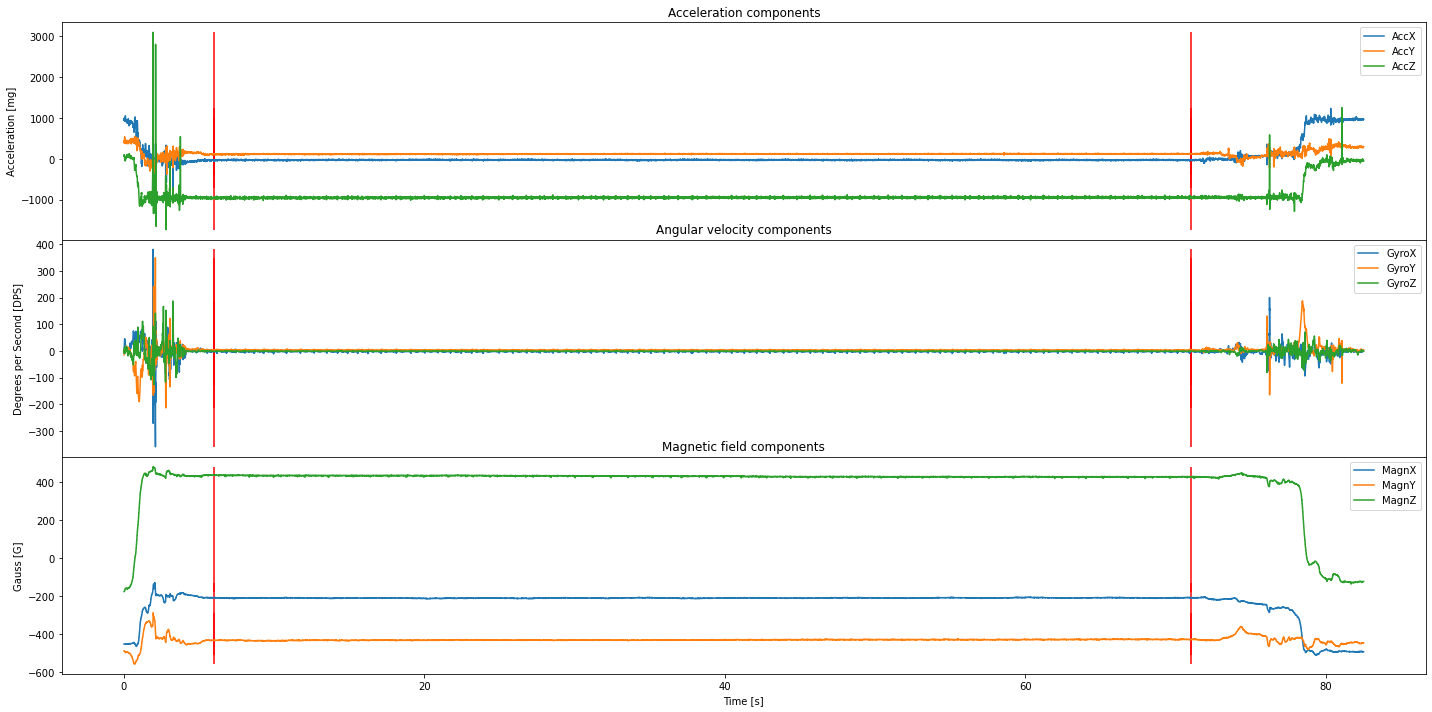

In [6]:
# now let's look at the acceleration vector by plotting its three components
acc_columns = ['AccX','AccY','AccZ']
gyro_columns = ['GyroX','GyroY','GyroZ']
magn_columns = ['MagnX','MagnY','MagnZ']

# we define the time-window based on a previous dataset exploration, in order to have the timestamp already represented on the plot
timestamp1 = 6
timestamp2 = 71

fig,axs = plt.subplots(3,1,sharex=True,figsize=[20,10],gridspec_kw={'hspace': 0})
# plot the acceleration vectors
axs[0].set_title('Acceleration components')
for acc in acc_columns:
    axs[0].vlines(timestamp1,df_init[acc].min(),df_init[acc].max(),color='red')
    axs[0].vlines(timestamp2,df_init[acc].min(),df_init[acc].max(),color='red')
    axs[0].plot(df_init.index,df_init[acc],label=acc)
    axs[0].set_ylabel('Acceleration [mg]')
# plot the angular velocity components
axs[1].set_title('Angular velocity components')
for gyro in gyro_columns:
    axs[1].vlines(timestamp1,df_init[gyro].min(),df_init[gyro].max(),color='red')
    axs[1].vlines(timestamp2,df_init[gyro].min(),df_init[gyro].max(),color='red')
    axs[1].plot(df_init.index,df_init[gyro],label=gyro)
    axs[1].set_ylabel('Degrees per Second [DPS]')
# plot the magnetic field components
axs[2].set_title('Magnetic field components')
for magn in magn_columns:
    axs[2].vlines(timestamp1,df_init[magn].min(),df_init[magn].max(),color='red')
    axs[2].vlines(timestamp2,df_init[magn].min(),df_init[magn].max(),color='red')
    axs[2].plot(df_init.index,df_init[magn],label=magn)
    axs[2].set_ylabel('Gauss [G]')
for ax in axs:   ax.legend()
axs[-1].set_xlabel('Time [s]')
fig.tight_layout()
plt.show()

The selected time-window contains the periodic signal we are interested in: let's work on the dataset corresponding to such subset. Also, we already subtract the offset given by the column's mean from each column using the convenient pandas implementation.

In [7]:
# let's restrict our working time window to the one presented in the plots
df =df_init.loc[timestamp1:timestamp2] # working on the 6s-71s subset
# let's already subtract the offset given by the mean
df = df-df.mean()

In [8]:
def sensor_plot(data_frame, sensor, title, unit):
    """
    Helper function to plot a sensor's components.
    title : string
    unit : string 
    sensor : list of 3 string
    """
    figure, axes = plt.subplots(1, 3, figsize=(22,3))
    figure.suptitle(title)    
    colors = ['C0','C1','C2']

    for i in range(3):
        data_frame.plot(ax=axes[i],y=sensor[i], ylabel= unit, xlabel='time [s]',color=colors[i])
    

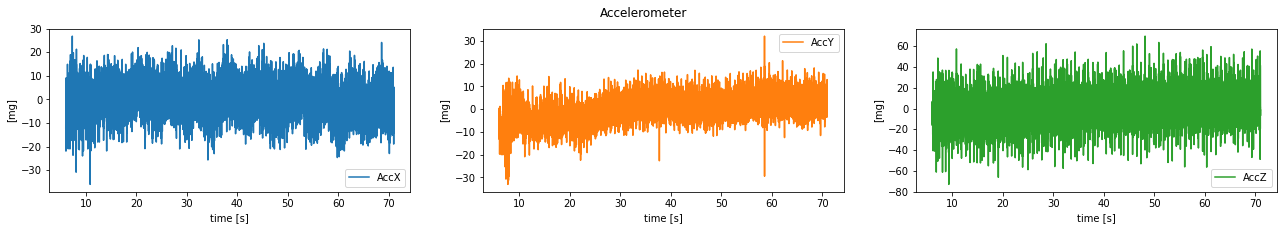

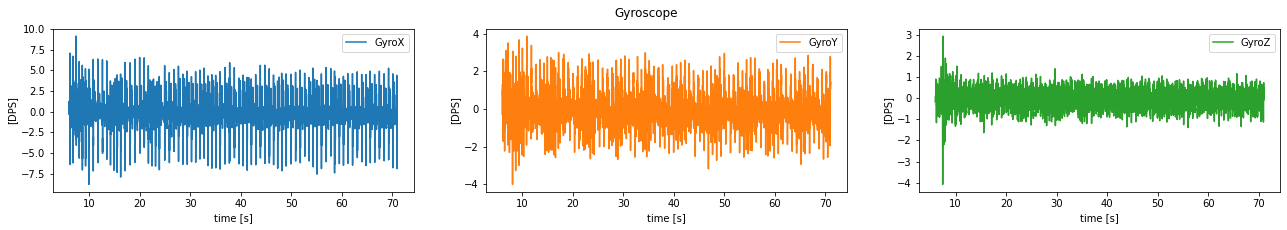

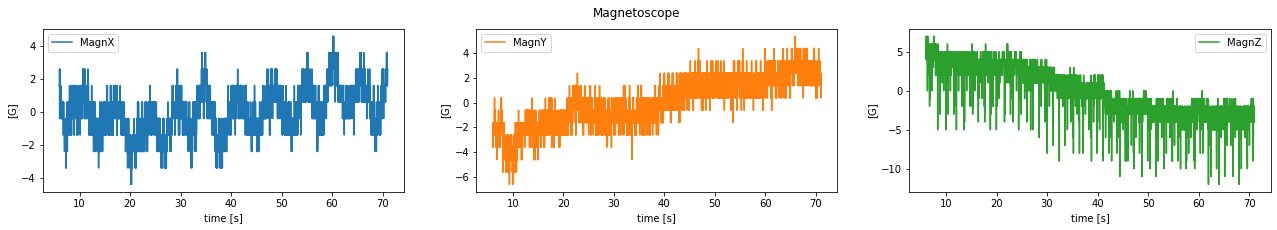

In [9]:
sensor_plot(df,acc_columns,'Accelerometer','[mg]')
sensor_plot(df,gyro_columns,'Gyroscope','[DPS]')
sensor_plot(df,magn_columns,'Magnetoscope','[G]')

From the plots shown above we observe, along with the low resolution of 1 Gauss of the magnetometer, the different contribution of the period signal we are looking for to different components: we can expect that, by performing a PCA, we should be able to transform the dataset into a frame of reference where the periodic signal varies mainly along one direction, assuming noise to be smaller w.r.t. the "true" signal; if that isn't the case, than variance due to gaussian noise is comparable to variance due to original signal, thus hijacking the PCA's purpose of finding the main direction of the signal.

In [10]:
def PCA_plot (data_frame, sensor, title, unit,sampling_rate=sampling_rate):
    """
    Helper function to perform PCA using sklearn's routine and plot its results.
    title : string
    unit : string 
    sensor : list of 3 string
    """
    sample_spacing = 1/sampling_rate

    pca=PCA(n_components=2) # initializing a PCA object with maximum number of kept components equal 2
    pca.fit(data_frame[sensor]) #fitting the PCA to selected sensor
    
    sensorT=pca.transform(data_frame[sensor]) # transform data; returns a np.array like (n_samples,n_components)
    
    sensorT_FT1=fft.fft(sensorT[:,0])
    sensorT_FT2=fft.fft(sensorT[:,1])
    sensorT_FT_freq=fft.fftfreq(sensorT[:,0].size,sample_spacing)
    N = int(sensorT_FT_freq.size/2) 
    
    with plt.rc_context({"figure.figsize" : (20,6)}):
        fig,axs = plt.subplots(2,2)
        fig.suptitle(title)
        axs[0,0].plot(data_frame.index,sensorT[:,0],label='First component',color='midnightblue')
        axs[0,0].legend(loc='upper right')
        axs[0,0].set_title("Transformed vector's components projection")
        axs[0,0].set_ylabel(unit)
        axs[0,1].plot(sensorT_FT_freq[:N],np.abs(sensorT_FT1[:N]),color='slateblue')
        axs[0,1].set_title("FT")
        axs[0,1].set_ylabel('power')
        axs[1,0].plot(data_frame.index,sensorT[:,1],label='Second component',color='firebrick')
        axs[1,0].legend(loc='upper right')
        axs[1,0].set_xlabel('time [s]')
        axs[1,0].set_ylabel(unit)
        axs[1,1].plot(sensorT_FT_freq[:N],np.abs(sensorT_FT2[:N]),color='tomato')
        axs[1,1].set_xlabel('frequency [Hz]')
        axs[1,1].set_ylabel('power');

    print('*',title,'\n')
    print("Percentage of variance due to the first component: {:.2%}".format(pca.explained_variance_ratio_[0]))
    print("Percentage of variance due to the second component: {:.2%}".format(pca.explained_variance_ratio_[1]),'\n')

    return sensorT

The code above also plots the FT of the transformed dataset's components, in order to get a feeling of the frequency representation of given signal.

* Accelerometer PCA 

Percentage of variance due to the first component: 75.92%
Percentage of variance due to the second component: 13.91% 

* Gyroscope PCA 

Percentage of variance due to the first component: 79.96%
Percentage of variance due to the second component: 15.95% 

* Magnetoscope PCA 

Percentage of variance due to the first component: 81.08%
Percentage of variance due to the second component: 10.23% 



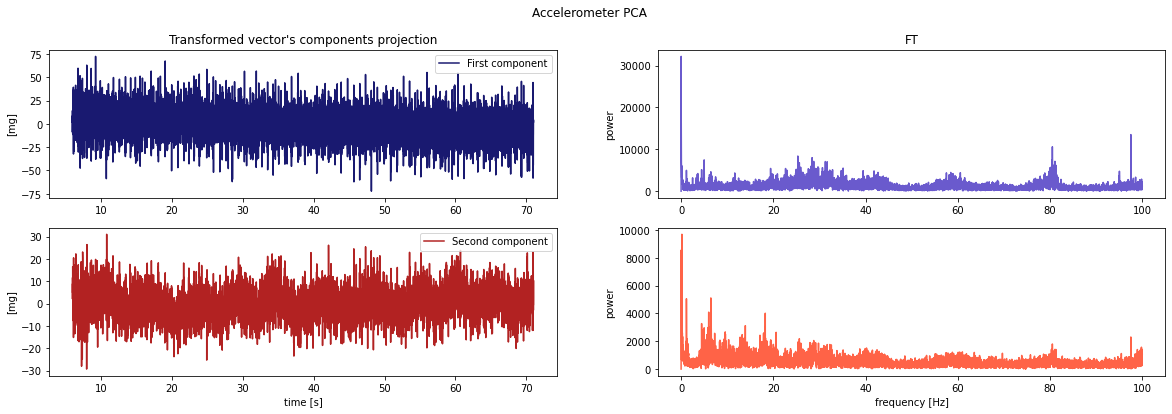

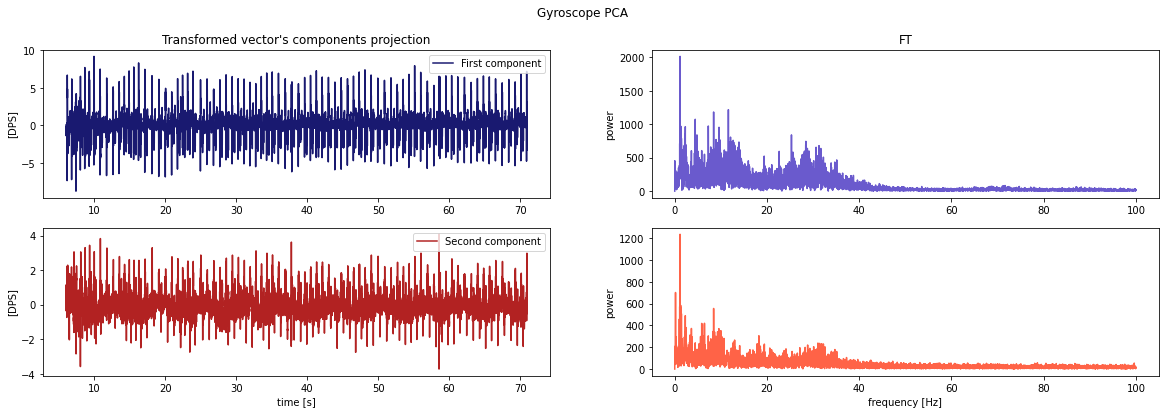

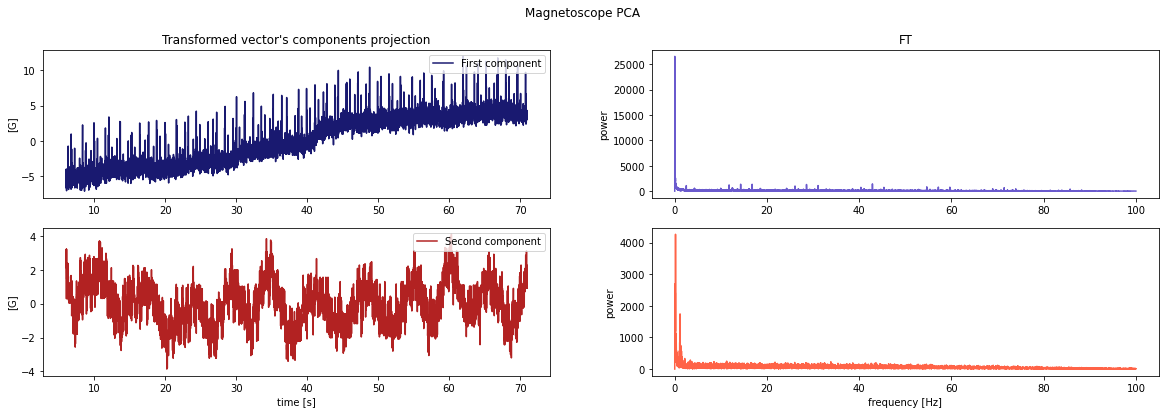

In [11]:
accT=PCA_plot(df,acc_columns,'Accelerometer PCA','[mg]')
gyroT=PCA_plot(df,gyro_columns,'Gyroscope PCA','[DPS]')
magnT=PCA_plot(df,magn_columns,'Magnetoscope PCA','[G]')

By observing the fourier transform of each PCA component, we can try to guess which of these components holds the main signal frequencies by looking at the spectrum near the low frequency spectrum ($\sim 10^{-1} Hz$).

A plain frequency analysis across the entire time domain doesn't inform us about time dependent information, such as the variability of the respiratory rate through the entire data acquisition. To perform some kind of time-frequency analysis, we resort to...

# Wavelet transformation

<center><img src="img/wavelet_analysis.png" width="450"/></center>
<center>Image taken from 
<a href="https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442">this</a>
 article.</center>

Standard Fourier Transform decomposes the signal in plane waves with fixed frequency, and infinite time span; by looking at the resulting coefficients, we cannot extrapolate any information regarding time-localized events and time dependent frequency information. To perform a *Time-Frequency Analysis* one has to deploy different mathematical machines; one could, for example, perform a FT over a restricted time window of the original signal (*Short time Fourier Transform*), or, better yet, decompose the signal into a 2-dimensional basis set of wave packets, localized at some point in time $\tau$. By computing the correlation between the signal and a wave packet of a given frequency localized at a given instant, we obtain a 2D transformation carrying both time and frequency information: this is exactly what the *wavelet transform* does.
The mathematical definition of a *continuous wavelet transform* is the following:
$$
cwt(\tau,s) = \frac{1}{\sqrt{|s|}} \int_{-\infty}^{+\infty} x(t) \psi(\frac{t-\tau}{s}) dt
$$
Where $\psi$ is the *mother wavelet*, i.e. the specific type of wave we convolve with our signal, and $s$ is the *scale factor* of such mother wavelet. The suitable type of wavelet depends on the problem at hand, and the scale factor basically determines the frequency of said wavelet packet.

<center><img src="img/Continuous_wavelet_transform.gif" width="450"/></center>
<center>Image taken from 
<a href="https://en.wikipedia.org/wiki/Continuous_wavelet_transform">Wikipedia</a>.</center>

## Wavelets

In our study case, we employ the <a href="https://pywavelets.readthedocs.io/en/latest/">Pywavelets</a> `pywt` package that implements the continuous wavelet transform and several types of wavelets to perform the transformation with. Let's start by obtaining the list of available wavelets:

In [12]:
c_wvlst=pywt.wavelist(kind='continuous')
print(c_wvlst)

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


Official <a href="https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#continuous-wavelet-families">Pywavelets documentation</a> provides a more detailed explanation of the previously printed wavelets, along with their mathematical formulation. Each of these wavelets has a "central frequency" $f_C$, i.e. the wave packet's peak frequency when its scale factor is set to 1. For instance, let's pick the Morlet wavelet `morl`, defined in the documentation as
$$
\psi_{Morlet}(t) = e^{-t^2/2}\cos(5t)
$$
When scaled by a factor of 1, this (and any other) wavepacket is evaluated within a range where it's assumed to be non-zero: when selecting a larger scale factor, the wavelet's range is extended by the same factor, making it more sensible to lower frequencies in the signal. Pywavelets allow us to explore these properties and the wavelet we've chosen:


Wavelet's name:  morl
Wavelet's upper bound:  8.0
Wavelet's lower bound:  -8.0
Is the wavelet biorthogonal?  False
Is the wavelet symmetric?  symmetric
Central frequency:  0.8125


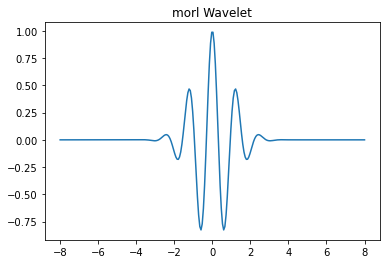

In [13]:
def get_wavelet_description(name):
    """
    Helper function to get informations about a Wavelet Object provided by the pywt package.
    name : string representing a wavelet name as defined by pywt.wavelist()
    """
    # initialize a wavelet object
    wav = pywt.ContinuousWavelet(name)
    wavy,wavx=wav.wavefun()
    print("Wavelet's name: ",wav.name)
    print("Wavelet's upper bound: ",wav.upper_bound)
    print("Wavelet's lower bound: ",wav.lower_bound)
    print("Is the wavelet biorthogonal? ",wav.biorthogonal)
    print("Is the wavelet symmetric? ",wav.symmetry)
    print("Central frequency: ",pywt.scale2frequency(wav,1)) #scale2frequency is a pywt function that returns the frequency at a given scale

    fig,ax = plt.subplots()
    ax.set_title('{} Wavelet'.format(name))
    ax.plot(wavx,wavy)
    plt.show()

get_wavelet_description('morl') #Morlet Wavelet

Note: the frequency returned by the function `scale2frequency` is a *pseudy-frequency* $\hat{f}$: it's only equal to the real physical frequency if the sampling period is assumed to be 1 s (sampling frequency of 1 Hz). In order to get the corresponding physical central frequency of it we need to multiply it by the sampling frequency:
$$
f_C = \hat{f_C}f_{sampling}
$$
Since the frequency of a wavelet is inversely proportional to the scale factor $f(s)=\hat{f_C}f_{sampling}/s$, in order to find the scale factor corresponding to a specific frequency we explicitate:
$$
s(f) = \frac{\hat{f_C}f_{sampling}}{f}
$$

This helps us set a minimum scale value, corresponding to the maximum frequency which turns out to be half the sampling frequency as per Nyquist-Shannon's theorem:

$$
s_{min} = 2\hat{f_C}
$$

Since we are looking for the Respiratory Rate, that usually spans between 12 and 20 BPM (0.2-0.33 Hz), we can also look for a maximum scale value that bring useful information, by looking the scale corresponding to, let's say, 0.1 Hz:

$$
s_{max} = \frac{\hat{f_C}f_{sampling}}{0.1}
$$

An example of these calculations is shown in the cell below:

In [14]:
minimum_frequency = 0.1 #Hz   <--- WATCH OUT if you use a very low frequency it relates to a very large wavelet bounds so calculation will take a long time
wav = pywt.ContinuousWavelet('morl') # Morlet Wavefunction
print("Central real frequency (Hz): ",pywt.scale2frequency(wav,1)*sampling_rate)
min_scale = pywt.scale2frequency(wav,1)*2
print("Minimum scale factor for a sampling frequency of {} Hz: {}".format(sampling_rate,min_scale))
max_scale = pywt.scale2frequency(wav,1)*sampling_rate/minimum_frequency
print("Maximum scale factor for a frequency of {} Hz: {}".format(minimum_frequency,max_scale))

Central real frequency (Hz):  162.5
Minimum scale factor for a sampling frequency of 200 Hz: 1.625
Maximum scale factor for a frequency of 0.1 Hz: 1625.0


Let us now define some functions that will perform the analysis for us on a given signal. We will perform CWT decomposing the original signal into `Nscales` different scaled wavelenghts, with the scaling factors equally spaced from one another within the range `[min_scale,max_scale]`; since, as shown before, $f \sim 1/s$, this results in non-linearly spaced frequency analysis, but the frequencies we're interested in (in the order of $\sim 10^{-1} Hz$) are nonetheless well-sampled.

In [15]:
def perform_CWT(data_in,wav,min_scale,max_scale,sampling_rate,Nscales=500):
    """
    Wrapper function for pywt.cwt that performs CWT with Nscales different 
    scaling factor, linearly spaced within the [min_scale,max_scale] interval.
    Arguments:
    data_in : np.array() of shape (n_samples) corresponding to the signal to be analyzed
    wav : string with wavelet name or wavelet object
    min_scale : minimum scale factor (related to the maximum frequency analyzed)
    max_scale : maximum scale factor (rel. to minimum frequency)
    sampling_rate : float, representing the signal's sampling rate in Hz
    Nscales : int, defaults to 500. Number of scaling factors used to decompose the signal.

    Returns :
    coefs : np.array() shaped like (n_scales,n_samples)
    scales : np.array() shaped like (n_scales), with each entry scales[i] being the scale factor used in coefs[i,:]
    cwt_freq : np.array() shaped like (n_scales), with the frequencies corresponding to the scale factors used
    """

    scales = np.linspace(min_scale,max_scale,Nscales)# linear scale definition
    # lets try to define a linear spacing in frequency space and transform it
    # scales=pywt.scale2frequency(wav,1)*sampling_rate*(np.linspace(minimum_frequency,sampling_rate/2,Nscales))**(-1)

    coefs, cwt_freq = pywt.cwt(data_in,scales,wav,sampling_period=1/sampling_rate) # result is (n_scales,n_points) np.array. coefs[0,:] are the coefficient for the first scale
                                                                            # which is the smaller one (higher frequency)
                                                                            # cwt_freq is a frequency array, corresponding to the scales array but transformed to a frequency
    return coefs,scales,cwt_freq

def plot_spectrogram(coefs,scales,t_series,name,absolute=True,cmap='viridis',peaks_t=None,peaks_s=None):
    """
    Function that plots the scalogram of the decomposed signal. 
    Plots the scalogram with x axis corresponding to the time-series (works by providing t0 and t1, assuming linearly time spaced samples)
    And y axis corresponding to scale array (assuming linearly spaced scale factors)
    Because of poorly implemented imshow() method of matplotlib.
    Arguments:
    coefs : np.array() shaped like (n_scales,n_samples)
    scales : np.array() shaped like (n_scales), with each entry scales[i] being the scale factor used in coefs[i,:]
    t_series : np.array() shaped like (n_samples), giving the timestamp of each sample
    name : string, representing the name of the signal decomposed
    absolute : bool, defaults to True: whether to consider the absolute value of coefficients or not.
    cmap : defaults to 'viridis', string representing a Matplotlib cmap name
    peaks_t : time-series indices coordinates for peaks found with some algorithm. Defaults to None, only plots them if given
    peaks_s : scales-series indices coordinates for peaks found with some algorithm. Defaults to None, only plots them if given
    """
    if absolute: 
        data = np.abs(coefs)
        cbar_label = 'CWT coefficients (absolute value)'
    else : 
        data = coefs
        cbar_label = 'CWT coefficients'
    fig,ax = plt.subplots(1,1,figsize=[20,8])
    fig.suptitle(name+' CWT scalogram')
    ax.set_ylabel('Wavelet Scale Factor')
    pos = ax.imshow(data,aspect='auto',extent=(t_series[0],t_series[-1],scales[-1],scales[1]),cmap=cmap)
    cbar=fig.colorbar(pos)
    cbar.set_label(cbar_label)
    ax.set_xlabel('Time (s)')

    if not (peaks_t is None) and not (peaks_s is None):
        ax.plot(t_series[peaks_t],scales[peaks_s],'ro')
    plt.show()

In [58]:
data = accT[:,1] #second component of acceleration PCA
coefs,scales,cwt_freq = perform_CWT(data,wav,min_scale,max_scale,sampling_rate)

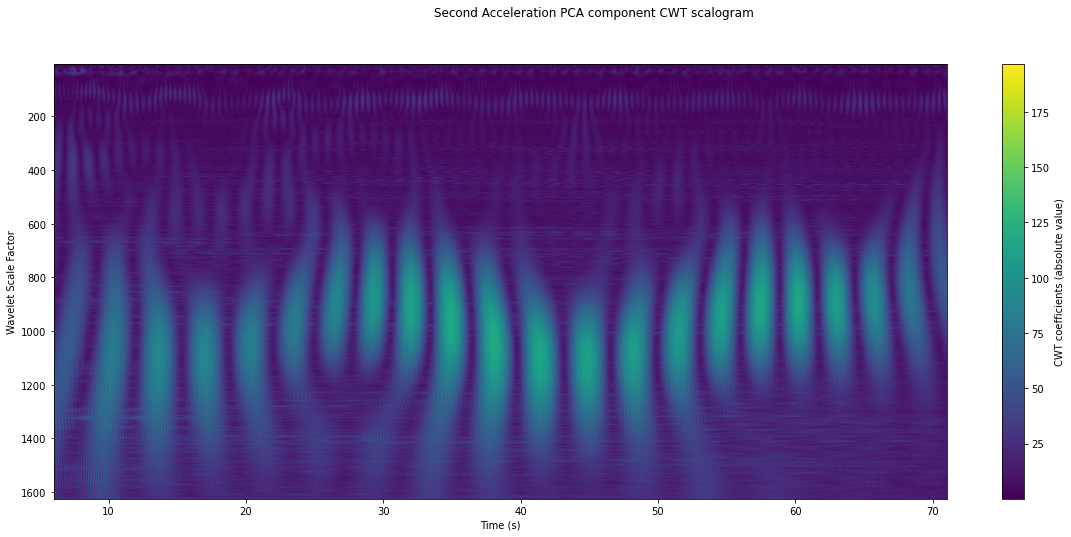

In [59]:
plot_spectrogram(coefs,scales,df.index,'Second Acceleration PCA component')

In [60]:
def return_peaks_coordinates(coefs,min_freq,max_freq,wav,sampling_rate):
    """
    This function takes in a CWT coefficient matrix shaped like (n_scales,n_points) and returns the peaks within a given wavelet C.F. bandwidth.
    coefs : (n_scales,n_points) np.array
    min_freq : float
    max_freq : float
    wav : wavelet name or object
    sampling_rate : float 

    Returns:
    peaks_t,peaks_s : touple of lists containing the temporal index and scale index to identify found peaks in the scalogram matrix
    """

    max_scale = pywt.scale2frequency(wav,1)*sampling_rate/min_freq
    min_scale = pywt.scale2frequency(wav,1)*sampling_rate/max_freq
    scale_range=np.argwhere(np.logical_and(scales < max_scale, scales > min_scale)).reshape(-1) # get the scale range
    mean=np.mean(np.abs(coefs[scale_range,:]),axis=0)
    from scipy import signal
    peaks_t,w=signal.find_peaks(mean,width=100) # get the peaks along temporal axis
    final_peaks_t = np.empty_like(peaks_t)
    final_peaks_s = np.empty_like(peaks_t)
    # print(peaks_t)
    for i,peak_t in enumerate(peaks_t):
        width = 100
        # print("Peak at time t",peak_t)
        max=np.max(np.abs(coefs)[:,peak_t-width:peak_t+width]) # get peaks along scales axis
        max_i=np.where(np.abs(coefs)[:,peak_t-width:peak_t+width]==max) # (scale_max,max_i)
        # print(max,max_i)    
        final_peaks_t[i] = peak_t-100+max_i[1]
        final_peaks_s[i] = max_i[0]
        # print("Coordinates for max {}: scale {} and time {}".format(max,final_peaks_s[i],final_peaks_t[i]))

    return final_peaks_t,final_peaks_s


def return_maximum(coefs,mean_freq,wav,sampling_rate):
    """
    Arguments:
    coefs : 2D np.array shaped like (n_scales,n_samples)
    mean_freq : the mean frequency of expected signal: this determines the scale of the gaussian kernel used to interpolate
    wav : wavelet name or Wavelet Object used to obtain coefs
    sampling_rate : float, the sampling rate of the signal   
    
    Returns:
    coefs_filtr : 2D np.array shaped like coefs, convoluted with the gaussian kernel
    s_max : np.array of shape (n_samples), with each entry being the index of the scale factor that corresponds to the maximum of the blurred scalogram at time t.  
    """

    sigma = (pywt.scale2frequency(wav,1)*sampling_rate/mean_freq)/2
    from scipy.ndimage import gaussian_filter
    coefs_filtr=gaussian_filter(np.abs(coefs),(1/sigma,sigma))
    s_max=np.argmax(coefs_filtr,axis=0)

    return coefs_filtr,s_max

In [61]:
coefs_filtr,s_max=return_maximum(coefs,0.26,'morl',sampling_rate)
time = np.arange(0,len(df.index))

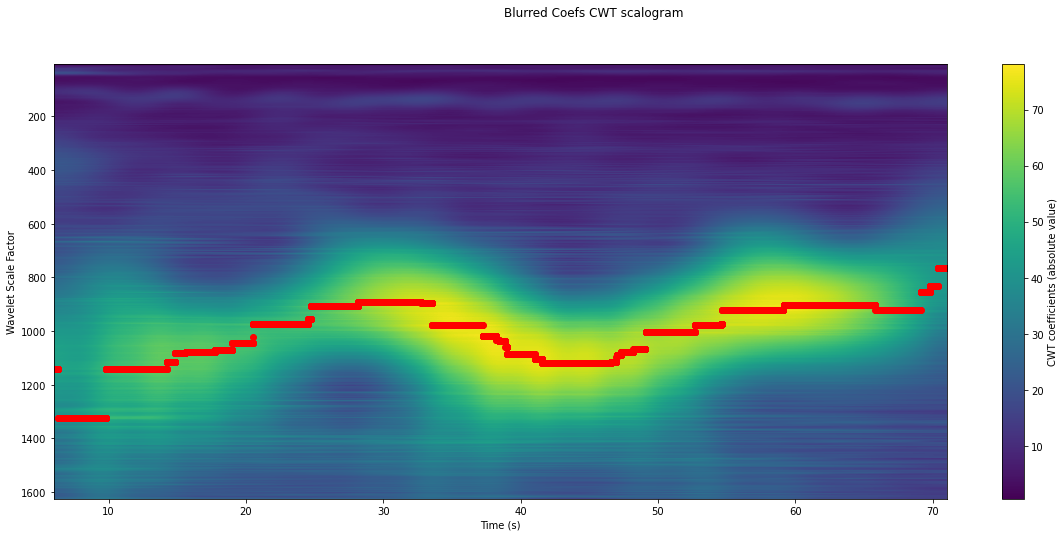

In [64]:
plot_spectrogram(coefs_filtr,scales,df.index,'Blurred Coefs',absolute=True,peaks_t=time,peaks_s=s_max)

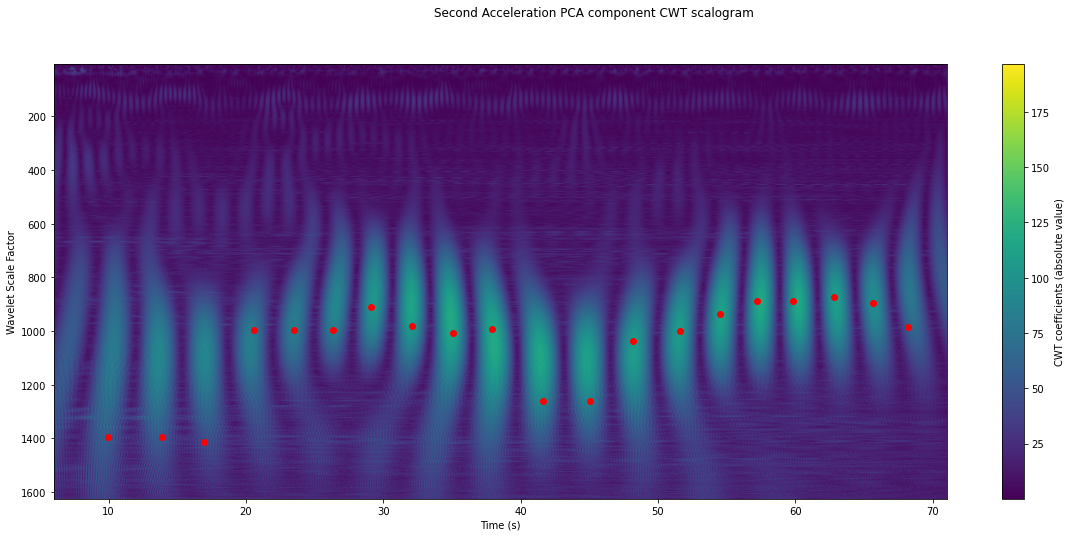

In [63]:
peaks_t,peaks_s = return_peaks_coordinates(coefs,0.1,0.4,wav,sampling_rate)
plot_spectrogram(coefs,scales,df.index,'Second Acceleration PCA component',peaks_t=peaks_t,peaks_s=peaks_s)

0.0007065217391304348


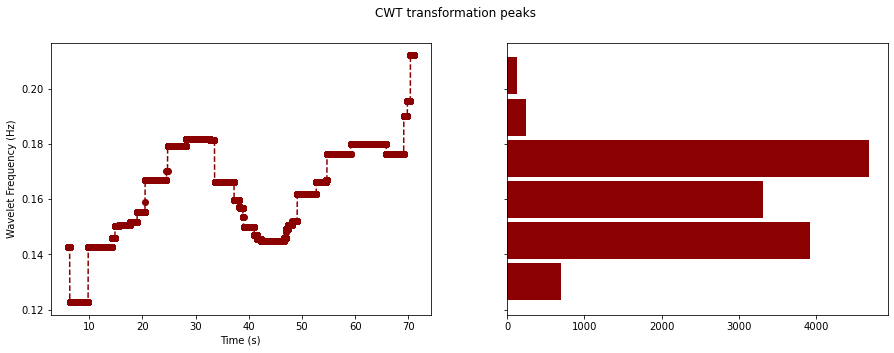

In [66]:
print(pywt.scale2frequency(wav,1150))

fig,axs = plt.subplots(1,2,figsize=[15,5],sharey=True)
fig.suptitle("CWT transformation peaks")

# t_p = df.index[peaks_t]
t_p = time
f_p = cwt_freq[s_max]

axs[0].set_ylabel("Wavelet Frequency (Hz)")
axs[0].set_xlabel("Time (s)")
axs[0].plot(df.index,f_p,linestyle='--',marker='o',color='darkred')
axs[1].hist(f_p,6,orientation='horizontal',rwidth=0.9,color='darkred')
plt.show()

## Short Time Fourier Transform shit

In [82]:
from scipy.signal import stft

data = df['AccX']

f,t,Zxx=stft(data,sampling_rate,nperseg=64)


In [83]:
print(f.shape)
print(t.shape)
print(Zxx.shape)

(33,)
(408,)
(33, 408)


Text(0, 0.5, 'Frequency (Hz)')

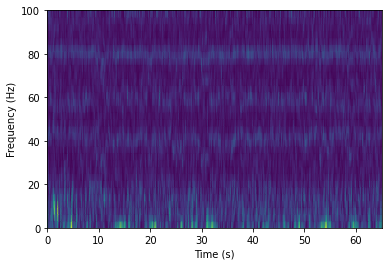

In [84]:
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=np.abs(Zxx).max(), shading='gouraud')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')